In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import math

class SelfAttention(nn.Module):
    def __init__(self, dim):
        super(SelfAttention, self).__init__()
        self.query = nn.Linear(dim, dim)
        self.key = nn.Linear(dim, dim)
        self.value = nn.Linear(dim, dim)
        self.scale = dim ** 0.5
    
    def forward(self, x):
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)
        attn_weights = torch.softmax(Q @ K.transpose(-2, -1) / self.scale, dim=-1)
        return attn_weights @ V

class TransformerPINN(nn.Module):
    def __init__(self, input_dim=6, hidden_dim=128, output_dim=1):  # Added yield strength as an input
        super(TransformerPINN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.attn = SelfAttention(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.attn(x)
        return self.fc2(x)

# Generate Synthetic FEA Data with Plasticity
def generate_synthetic_data(n_samples=1000):
    X = torch.rand((n_samples, 2))  # 2D coordinates
    E = torch.rand((n_samples, 1)) * 200 + 50  # Young's modulus (random between 50-250 GPa)
    nu = torch.rand((n_samples, 1)) * 0.3  # Poisson's ratio (0-0.3)
    t = torch.rand((n_samples, 1)) * 10  # Time (0-10s)
    sigma_y = torch.rand((n_samples, 1)) * 300 + 100  # Yield strength (100-400 MPa)
    
    stress = E * (X[:, 0:1] + X[:, 1:2]) * torch.sin(0.5 * math.pi * t)
    plastic_mask = stress > sigma_y
    stress[plastic_mask] = sigma_y[plastic_mask]  # Plastic deformation cap
    
    X = torch.cat([X, E, nu, t, sigma_y], dim=1)
    return X, stress

# Physics-Informed Loss Function with Plasticity Constraints
def physics_loss(model, X):
    X.requires_grad = True
    stress_pred = model(X)
    stress_grad = torch.autograd.grad(stress_pred.sum(), X, create_graph=True)[0]
    equilibrium = stress_grad[:, 0] + stress_grad[:, 1]  # Simplified equilibrium equation
    
    # Apply Dirichlet boundary conditions (stress = 0 at domain edges)
    boundary_mask = (X[:, 0] < 0.05) | (X[:, 0] > 0.95) | (X[:, 1] < 0.05) | (X[:, 1] > 0.95)
    boundary_loss = torch.mean(stress_pred[boundary_mask] ** 2)
    
    # Apply Neumann boundary conditions (dynamic external forces)
    force_positions = [(0.9, 0.5), (0.5, 0.9)]  # Force applied at right edge and top center
    neumann_loss = 0
    
    for (fx, fy) in force_positions:
        force_mask = ((X[:, 0] - fx).abs() < 0.05) & ((X[:, 1] - fy).abs() < 0.05)
        force_value = 100.0 * torch.sin(0.5 * math.pi * X[:, -2][force_mask])  # Dynamic force over time
        neumann_loss += torch.mean((stress_grad[force_mask, 0] - force_value) ** 2)
    
    # Enforce plasticity constraints (stress cannot exceed yield strength)
    sigma_y = X[:, -1].unsqueeze(-1)
    plasticity_loss = torch.mean(torch.relu(stress_pred - sigma_y) ** 2)
    
    return torch.mean(equilibrium**2) + boundary_loss + neumann_loss + plasticity_loss

# Sample Training Code
def train(model, optimizer, epochs=500):
    for epoch in range(epochs):
        X, stress = generate_synthetic_data(100)  # Generate new synthetic data each epoch
        loss = physics_loss(model, X)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epoch % 50 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")

# Initialize and Train
model = TransformerPINN()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train(model, optimizer)

# 2. Strain Hardenning


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import math

class SelfAttention(nn.Module):
    def __init__(self, dim):
        super(SelfAttention, self).__init__()
        self.query = nn.Linear(dim, dim)
        self.key = nn.Linear(dim, dim)
        self.value = nn.Linear(dim, dim)
        self.scale = dim ** 0.5
    
    def forward(self, x):
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)
        attn_weights = torch.softmax(Q @ K.transpose(-2, -1) / self.scale, dim=-1)
        return attn_weights @ V

class TransformerPINN(nn.Module):
    def __init__(self, input_dim=7, hidden_dim=128, output_dim=1):  # Added strain-hardening coefficient
        super(TransformerPINN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.attn = SelfAttention(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.attn(x)
        return self.fc2(x)

# Generate Synthetic FEA Data with Strain-Hardening
def generate_synthetic_data(n_samples=1000):
    X = torch.rand((n_samples, 2))  # 2D coordinates
    E = torch.rand((n_samples, 1)) * 200 + 50  # Young's modulus (random between 50-250 GPa)
    nu = torch.rand((n_samples, 1)) * 0.3  # Poisson's ratio (0-0.3)
    t = torch.rand((n_samples, 1)) * 10  # Time (0-10s)
    sigma_y = torch.rand((n_samples, 1)) * 300 + 100  # Yield strength (100-400 MPa)
    strain_hardening = torch.rand((n_samples, 1)) * 50 + 10  # Strain-hardening coefficient (10-60 MPa)
    
    stress = E * (X[:, 0:1] + X[:, 1:2]) * torch.sin(0.5 * math.pi * t)
    plastic_mask = stress > sigma_y
    stress[plastic_mask] = sigma_y[plastic_mask] + strain_hardening[plastic_mask] * (stress[plastic_mask] - sigma_y[plastic_mask])
    
    X = torch.cat([X, E, nu, t, sigma_y, strain_hardening], dim=1)
    return X, stress

# Physics-Informed Loss Function with Strain-Hardening Constraints
def physics_loss(model, X):
    X.requires_grad = True
    stress_pred = model(X)
    stress_grad = torch.autograd.grad(stress_pred.sum(), X, create_graph=True)[0]
    equilibrium = stress_grad[:, 0] + stress_grad[:, 1]  # Simplified equilibrium equation
    
    # Apply Dirichlet boundary conditions (stress = 0 at domain edges)
    boundary_mask = (X[:, 0] < 0.05) | (X[:, 0] > 0.95) | (X[:, 1] < 0.05) | (X[:, 1] > 0.95)
    boundary_loss = torch.mean(stress_pred[boundary_mask] ** 2)
    
    # Apply Neumann boundary conditions (dynamic external forces)
    force_positions = [(0.9, 0.5), (0.5, 0.9)]  # Force applied at right edge and top center
    neumann_loss = 0
    
    for (fx, fy) in force_positions:
        force_mask = ((X[:, 0] - fx).abs() < 0.05) & ((X[:, 1] - fy).abs() < 0.05)
        force_value = 100.0 * torch.sin(0.5 * math.pi * X[:, -2][force_mask])  # Dynamic force over time
        neumann_loss += torch.mean((stress_grad[force_mask, 0] - force_value) ** 2)
    
    # Enforce plasticity constraints with strain hardening
    sigma_y = X[:, -2].unsqueeze(-1)
    strain_hardening = X[:, -1].unsqueeze(-1)
    plasticity_loss = torch.mean(torch.relu(stress_pred - (sigma_y + strain_hardening * (stress_pred - sigma_y))) ** 2)
    
    return torch.mean(equilibrium**2) + boundary_loss + neumann_loss + plasticity_loss

# Sample Training Code
def train(model, optimizer, epochs=500):
    for epoch in range(epochs):
        X, stress = generate_synthetic_data(100)  # Generate new synthetic data each epoch
        loss = physics_loss(model, X)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epoch % 50 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")

# Initialize and Train
model = TransformerPINN()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train(model, optimizer)


# 3.FEA with TPINN


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
import pandas as pd

class SelfAttention(nn.Module):
    def __init__(self, dim):
        super(SelfAttention, self).__init__()
        self.query = nn.Linear(dim, dim)
        self.key = nn.Linear(dim, dim)
        self.value = nn.Linear(dim, dim)
        self.scale = dim ** 0.5
    
    def forward(self, x):
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)
        attn_weights = torch.softmax(Q @ K.transpose(-2, -1) / self.scale, dim=-1)
        return attn_weights @ V

class TransformerPINN(nn.Module):
    def __init__(self, input_dim=7, hidden_dim=128, output_dim=1):  
        super(TransformerPINN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.attn = SelfAttention(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.attn(x)
        return self.fc2(x)

# Load FEA Data from CSV
def load_fea_data(csv_path):
    df = pd.read_csv(csv_path)
    required_columns = ['x', 'y', 'E', 'nu', 't', 'sigma_y', 'strain_hardening', 'stress']
    df = df[required_columns]

    # Normalize large-scale values to prevent instability
    df['E'] /= 1e9  # Normalize Young's modulus
    df['sigma_y'] /= 1e6  # Normalize yield stress
    df['strain_hardening'] /= 1e6  # Normalize strain hardening
    df['stress'] /= 1e6  # Normalize stress

    X = torch.tensor(df[['x', 'y', 'E', 'nu', 't', 'sigma_y', 'strain_hardening']].values, dtype=torch.float32)
    stress = torch.tensor(df['stress'].values, dtype=torch.float32).unsqueeze(-1)

    return X, stress

# Physics-Informed Loss Function
def physics_loss(model, X, stress_true):
    X.requires_grad = True
    stress_pred = model(X)
    stress_grad = torch.autograd.grad(stress_pred.sum(), X, create_graph=True)[0]
    equilibrium = stress_grad[:, 0] + stress_grad[:, 1]  # Simplified equilibrium equation
    
    # Dirichlet Boundary Conditions (stress = 0 at edges)
    boundary_mask = (X[:, 0] < 0.05) | (X[:, 0] > 0.95) | (X[:, 1] < 0.05) | (X[:, 1] > 0.95)
    boundary_loss = torch.mean(stress_pred[boundary_mask] ** 2)
    
    # Neumann Boundary Conditions (dynamic external forces)
    force_positions = [(0.9, 0.5), (0.5, 0.9)]
    neumann_loss = 0
    
    for (fx, fy) in force_positions:
        force_mask = ((X[:, 0] - fx).abs() < 0.05) & ((X[:, 1] - fy).abs() < 0.05)
        force_value = 100.0 * torch.sin(0.5 * math.pi * X[:, -2][force_mask])  # Dynamic force
        neumann_loss += torch.mean((stress_grad[force_mask, 0] - force_value) ** 2)
    
    # Plasticity constraints with strain hardening
    sigma_y = X[:, -2].unsqueeze(-1)
    strain_hardening = X[:, -1].unsqueeze(-1)
    
    # ⚠ FIXED: Move `eps` inside `relu()` to prevent instability
    eps = 1e-6
    plasticity_constraint = sigma_y + strain_hardening * (stress_pred - sigma_y)
    plasticity_loss = torch.mean(torch.relu(stress_pred - plasticity_constraint) ** 2 + eps)

    # Compare with actual FEA stress data
    fea_loss = torch.mean((stress_pred - stress_true) ** 2)
    
    return torch.mean(equilibrium**2) + boundary_loss + neumann_loss + plasticity_loss + fea_loss

# Sample Training Code with Gradient Clipping
def train(model, optimizer, csv_path, epochs=500):
    for epoch in range(epochs):
        X, stress_true = load_fea_data(csv_path)  # Load FEA data from CSV
        loss = physics_loss(model, X, stress_true)
        optimizer.zero_grad()
        loss.backward()

        # ✅ Gradient Clipping to Prevent Exploding Gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()

        if epoch % 50 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")

# Initialize and Train
csv_path = 'fea_data.csv'  # Replace with actual file path
model = TransformerPINN()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train(model, optimizer, csv_path)


In [ ]:
import torch

# Function to Evaluate Model
def evaluate(model, csv_path, device="cpu"):
    model.to(device)
    model.eval()  # Set model to evaluation mode

    # Load test data from CSV
    X_test, stress_true = load_fea_data(csv_path)
    X_test, stress_true = X_test.to(device), stress_true.to(device)  # Ensure proper device

    with torch.no_grad():  # No gradients needed for inference
        stress_pred = model(X_test)

    # Compute evaluation metrics
    mae = torch.mean(torch.abs(stress_pred - stress_true)).item()
    mse = torch.mean((stress_pred - stress_true) ** 2).item()  # Added MSE metric

    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Squared Error (MSE): {mse}")

    # Return predictions in NumPy format for visualization
    return stress_pred.cpu().numpy(), stress_true.cpu().numpy()

# Run Evaluation
stress_pred, stress_true = evaluate(model, csv_path)



## Evaluations and prediction


In [ ]:
import matplotlib.pyplot as plt
import torch

# Force CPU execution
device = torch.device("cpu")
model.to(device)

# Load test data from the synthetic CSV
X_test, stress_true = load_fea_data("fea_data.csv")
X_test, stress_true = X_test.to(device), stress_true.to(device)

# Run model evaluation
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    stress_pred = model(X_test)

# Convert to numpy for plotting (Denormalize stress if normalized)
stress_true_np = (stress_true.cpu().numpy().flatten()) * 1e6  # Convert back to Pascals
stress_pred_np = (stress_pred.cpu().numpy().flatten()) * 1e6  # Convert back to Pascals

# Scatter plot: True vs. Predicted Stress
plt.figure(figsize=(8, 6))
plt.scatter(stress_true_np, stress_pred_np, alpha=0.5, label="Predicted vs. True")
plt.plot([stress_true_np.min(), stress_true_np.max()], 
         [stress_true_np.min(), stress_true_np.max()], 'r--', label="Ideal Fit (y=x)")
plt.xlabel("True Stress (Pa)")
plt.ylabel("Predicted Stress (Pa)")
plt.title("FEA Model Prediction vs. Ground Truth")
plt.legend()
plt.grid(True)

# Save the plot
plot_path = "stress_prediction_plot.png"
plt.savefig(plot_path)
plt.show()

# Return the plot path
print(f"Prediction plot saved at: {plot_path}")


In [ ]:
import torch

# Force CPU execution
device = torch.device("cpu")

# Generate new test input (not in CSV) for inference
new_test_sample = torch.tensor([[0.75, 0.25, 180e9, 0.3, 0.01, 300e6, 200e6]], dtype=torch.float32).to(device)

# Normalize input (same as done in training)
new_test_sample[:, 2] /= 1e9  # Normalize Young's modulus (E)
new_test_sample[:, 5] /= 1e6  # Normalize yield stress (sigma_y)
new_test_sample[:, 6] /= 1e6  # Normalize strain hardening

# Run inference
model.eval()
with torch.no_grad():
    new_stress_pred = model(new_test_sample)

# Denormalize output stress (convert back to Pascals)
new_stress_value = new_stress_pred.item() * 1e6  # Convert back from normalized units

print(f"Predicted Stress for New Input: {new_stress_value} Pa")


# 3.MultiHead


In [80]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
import pandas as pd

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, dim, num_heads=4):
        super(MultiHeadSelfAttention, self).__init__()
        assert dim % num_heads == 0, "Hidden dimension must be divisible by number of heads"

        self.num_heads = num_heads
        self.head_dim = dim // num_heads  # Dimension per head

        # Learnable weights for Query, Key, Value
        self.query = nn.Linear(dim, dim)
        self.key = nn.Linear(dim, dim)
        self.value = nn.Linear(dim, dim)

        # Output projection layer
        self.fc_out = nn.Linear(dim, dim)

        self.scale = self.head_dim ** 0.5  # Scaling factor

    def forward(self, x):
        batch_size, seq_len, dim = x.shape  # Assuming (batch, sequence_length, embedding_dim)
        
        # Linear projections: (batch, seq_len, dim) → (batch, seq_len, num_heads, head_dim)
        Q = self.query(x).view(batch_size, seq_len, self.num_heads, self.head_dim)
        K = self.key(x).view(batch_size, seq_len, self.num_heads, self.head_dim)
        V = self.value(x).view(batch_size, seq_len, self.num_heads, self.head_dim)

        # Transpose to (batch, num_heads, seq_len, head_dim) for computation
        Q = Q.transpose(1, 2)
        K = K.transpose(1, 2)
        V = V.transpose(1, 2)

        # Scaled dot-product attention
        attn_weights = torch.softmax(Q @ K.transpose(-2, -1) / self.scale, dim=-1)  # Shape: (batch, num_heads, seq_len, seq_len)
        attn_output = attn_weights @ V  # Shape: (batch, num_heads, seq_len, head_dim)

        # Concatenate multiple attention heads (batch, seq_len, num_heads * head_dim)
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, seq_len, dim)

        # Final linear transformation
        return self.fc_out(attn_output)

class TransformerPINN(nn.Module):
    def __init__(self, input_dim=7, hidden_dim=128, output_dim=1, num_heads=4):  
        super(TransformerPINN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.attn = MultiHeadSelfAttention(hidden_dim, num_heads)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x)).unsqueeze(1)  # Add sequence dimension (batch, seq_len=1, hidden_dim)
        x = self.attn(x).squeeze(1)  # Remove sequence dimension
        return self.fc2(x)

# Load FEA Data from CSV
def load_fea_data(csv_path):
    df = pd.read_csv(csv_path)
    required_columns = ['x', 'y', 'E', 'nu', 't', 'sigma_y', 'strain_hardening', 'stress']
    df = df[required_columns]

    # Normalize large-scale values to prevent instability
    df['E'] /= 1e9  # Normalize Young's modulus
    df['sigma_y'] /= 1e6  # Normalize yield stress
    df['strain_hardening'] /= 1e6  # Normalize strain hardening
    df['stress'] /= 1e6  # Normalize stress

    X = torch.tensor(df[['x', 'y', 'E', 'nu', 't', 'sigma_y', 'strain_hardening']].values, dtype=torch.float32)
    stress = torch.tensor(df['stress'].values, dtype=torch.float32).unsqueeze(-1)

    return X, stress

# Physics-Informed Loss Function
def physics_loss(model, X, stress_true):
    X.requires_grad = True
    stress_pred = model(X)
    stress_grad = torch.autograd.grad(stress_pred.sum(), X, create_graph=True)[0]
    equilibrium = stress_grad[:, 0] + stress_grad[:, 1]  # Simplified equilibrium equation
    
    # Dirichlet Boundary Conditions (stress = 0 at edges)
    boundary_mask = (X[:, 0] < 0.05) | (X[:, 0] > 0.95) | (X[:, 1] < 0.05) | (X[:, 1] > 0.95)
    boundary_loss = torch.mean(stress_pred[boundary_mask] ** 2)
    
    # Neumann Boundary Conditions (dynamic external forces)
    force_positions = [(0.9, 0.5), (0.5, 0.9)]
    neumann_loss = 0
    
    for (fx, fy) in force_positions:
        force_mask = ((X[:, 0] - fx).abs() < 0.05) & ((X[:, 1] - fy).abs() < 0.05)
        force_value = 100.0 * torch.sin(0.5 * math.pi * X[:, -2][force_mask])  # Dynamic force
        neumann_loss += torch.mean((stress_grad[force_mask, 0] - force_value) ** 2)
    
    # Plasticity constraints with strain hardening
    sigma_y = X[:, -2].unsqueeze(-1)
    strain_hardening = X[:, -1].unsqueeze(-1)
    
    eps = 1e-6
    plasticity_constraint = sigma_y + strain_hardening * (stress_pred - sigma_y)
    plasticity_loss = torch.mean(torch.relu(stress_pred - plasticity_constraint) ** 2 + eps)

    # Compare with actual FEA stress data
    fea_loss = torch.mean((stress_pred - stress_true) ** 2)
    
    return torch.mean(equilibrium**2) + boundary_loss + neumann_loss + plasticity_loss + fea_loss

# Sample Training Code with Gradient Clipping
def train(model, optimizer, csv_path, epochs=500):
    for epoch in range(epochs):
        X, stress_true = load_fea_data(csv_path)  # Load FEA data from CSV
        loss = physics_loss(model, X, stress_true)
        optimizer.zero_grad()
        loss.backward()

        # ✅ Gradient Clipping to Prevent Exploding Gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()

        if epoch % 50 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")

# Initialize and Train
csv_path = 'fea_data.csv'  # Replace with actual file path
model = TransformerPINN(num_heads=4)  # Use 4 attention heads
optimizer = optim.Adam(model.parameters(), lr=0.001)
train(model, optimizer, csv_path)


Epoch 0, Loss: 5233534976.0
Epoch 50, Loss: 27768090.0
Epoch 100, Loss: 153224.578125
Epoch 150, Loss: 136682.9375
Epoch 200, Loss: 186240.046875
Epoch 250, Loss: 136732.359375
Epoch 300, Loss: 423121.78125
Epoch 350, Loss: 137408.734375
Epoch 400, Loss: 169361.65625
Epoch 450, Loss: 138605.71875


In [81]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate_model(model, csv_path):
    # Load test data
    X_test, stress_true = load_fea_data(csv_path)

    # Model inference (disable gradient computation for efficiency)
    model.eval()
    with torch.no_grad():
        stress_pred = model(X_test)

    # Compute evaluation metrics
    mse = mean_squared_error(stress_true.numpy(), stress_pred.numpy())
    mae = mean_absolute_error(stress_true.numpy(), stress_pred.numpy())

    print(f"Model Evaluation Results:\nMSE: {mse:.6f}\nMAE: {mae:.6f}")
    
    return stress_pred.numpy(), stress_true.numpy()


In [82]:
# Run Evaluation & Prediction
csv_path_test = 'fea_data.csv'  # Replace with test dataset file
predicted_stress, true_stress = evaluate_model(model, csv_path_test)



Model Evaluation Results:
MSE: 10062.475586
MAE: 91.112717


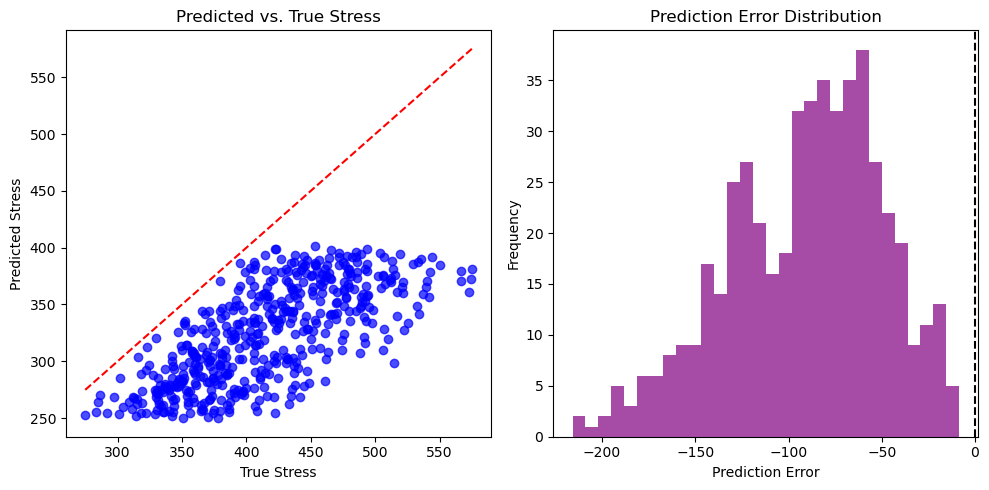

In [85]:
import matplotlib.pyplot as plt
import numpy as np

def plot_results(predicted, true):
    plt.figure(figsize=(10, 5))
    
    # Scatter plot of predicted vs actual stress values
    plt.subplot(1, 2, 1)
    plt.scatter(true, predicted, alpha=0.7, color="blue")
    plt.plot([min(true), max(true)], [min(true), max(true)], color="red", linestyle="--")
    plt.xlabel("True Stress")
    plt.ylabel("Predicted Stress")
    plt.title("Predicted vs. True Stress")
    
    # Histogram of prediction errors
    plt.subplot(1, 2, 2)
    errors = np.array(predicted) - np.array(true)
    plt.hist(errors, bins=30, color="purple", alpha=0.7)
    plt.axvline(0, color="black", linestyle="--")
    plt.xlabel("Prediction Error")
    plt.ylabel("Frequency")
    plt.title("Prediction Error Distribution")

    plt.tight_layout()
    plt.show()

# Visualize predictions
plot_results(predicted_stress, true_stress)
